# 💰 Détection des faux Billets

Ce projet a pour but de créer un algorithme de détection de faux billets et revoir des notions vues aux épisodes précédents.

Le [jeu de données](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/notes.csv)  contenant les caractéristiques géométriques de billets de banque. Pour chacun d'eux, nous connaissons :

 - la longueur du billet (en mm) ;  
 - la hauteur du billet (mesurée sur le côté gauche, en mm) ;  
 - La hauteur du billet (mesurée sur le côté droit, en mm) ;  
 - la marge entre le bord supérieur du billet et l'image de celui-ci (en mm) ;  
 - la marge entre le bord inférieur du billet et l'image de celui-ci (en mm) ;  
 - la diagonale du billet (en mm).

L'étude va consister en 3 parties : 

Partie 1 : analyse exploratoire univariée et bivariée de votre jeu de données  

Partie 2 : ACP 
    Vous réaliserez une analyse en composantes principales de l'échantillon, en suivant toutes ces étapes :  
        - choix du nombre des composantes
        - représentation des variables par le cercle des corrélations 
        - représentation des individus par les plans factoriels 
        - analyser de la qualité de représentation et la contribution des individus.
Pour chacune de ces étapes, commentez les résultats obtenus. La variable donnant la nature Vrai/Faux du billet sera utilisée comme variable illustrative.

Partie 3 : Réaliser une classification des billets (révisions de kmeans ou régression logique, et aller creuser côté CAH)

# Sommaire:  
* [Importation des librairies](#Importation-des-Librairies-📚)
<br>
* [Partie 1 : Analyses Bivaries](#Partie-1-:-ANALYSES-BIVARIES)
    * [Visualitsation du Dataset](#Visualisation-du-Dataset-📊)
    * [Encoding the genuine Variable](#Encoding-the-genuine-Variable)
* [Partie 2 : Analyse en Composantes Principales](#Partie-2-:-ANALYSE-EN-COMPOSANTES-PRINCIPALES)
    * [Analyse de la Composante Principale](#Analyse-de-la-Composante-Principale)
    * [Cercle des Corrélations](#Cercle-des-Corrélations)
    * [Représenation des Individus](#représentation-des-individus)
* [Partie 3 : Prédiction](#Partie-3-:-PREDICTION)
    * [Train and Test Data](#🏋%EF%B8%8F%E2%80%8D♀%EF%B8%8FTrain-and-Test-Data)
    * [Régression Logistique](#Regression-Logistique)
    * [Modèle de K-Means](#Modèle-de-K-Means)
    * [Dendrograme](#Dendrograme)

# Importation des Librairies 📚

In [1]:
# Import des librairies
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
#classe pour l'ACP
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

#RegLog Kmeans
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

#CAH
from scipy.cluster.hierarchy import dendrogram, linkage

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools import add_constant
from statsmodels.api import Logit


## Partie 1 : ANALYSES BIVARIES

Dans cette partie, vous allez explorer vos données via des visualisations, par exemple :   
    
    - le nombre de billets vrai/faux  
    - les distributions de longueurs, largeurs and co des billets de votre dataset
    - longueur/largeur and co des billets vrais vs. faux : est-ce que visuellement on peut déterminer des caractéristiques des vrais ou des faux billets ?
    - etc -> be creative :)

In [2]:
df = pd.read_csv('notes.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    170 non-null    bool   
 1   diagonal      170 non-null    float64
 2   height_left   170 non-null    float64
 3   height_right  170 non-null    float64
 4   margin_low    170 non-null    float64
 5   margin_up     170 non-null    float64
 6   length        170 non-null    float64
dtypes: bool(1), float64(6)
memory usage: 8.3 KB


No duplicated Data. No missing data
The Target is Boolean value

In [3]:
df['is_genuine'].value_counts()

True     100
False     70
Name: is_genuine, dtype: int64

# Visualisation du Dataset 📊

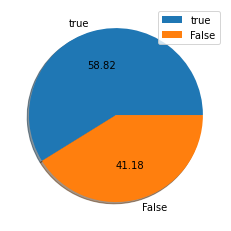

In [4]:
labels=['true','False']
plt.pie(df['is_genuine'].value_counts(),labels=labels,autopct='%.2f', shadow=True)
plt.legend()

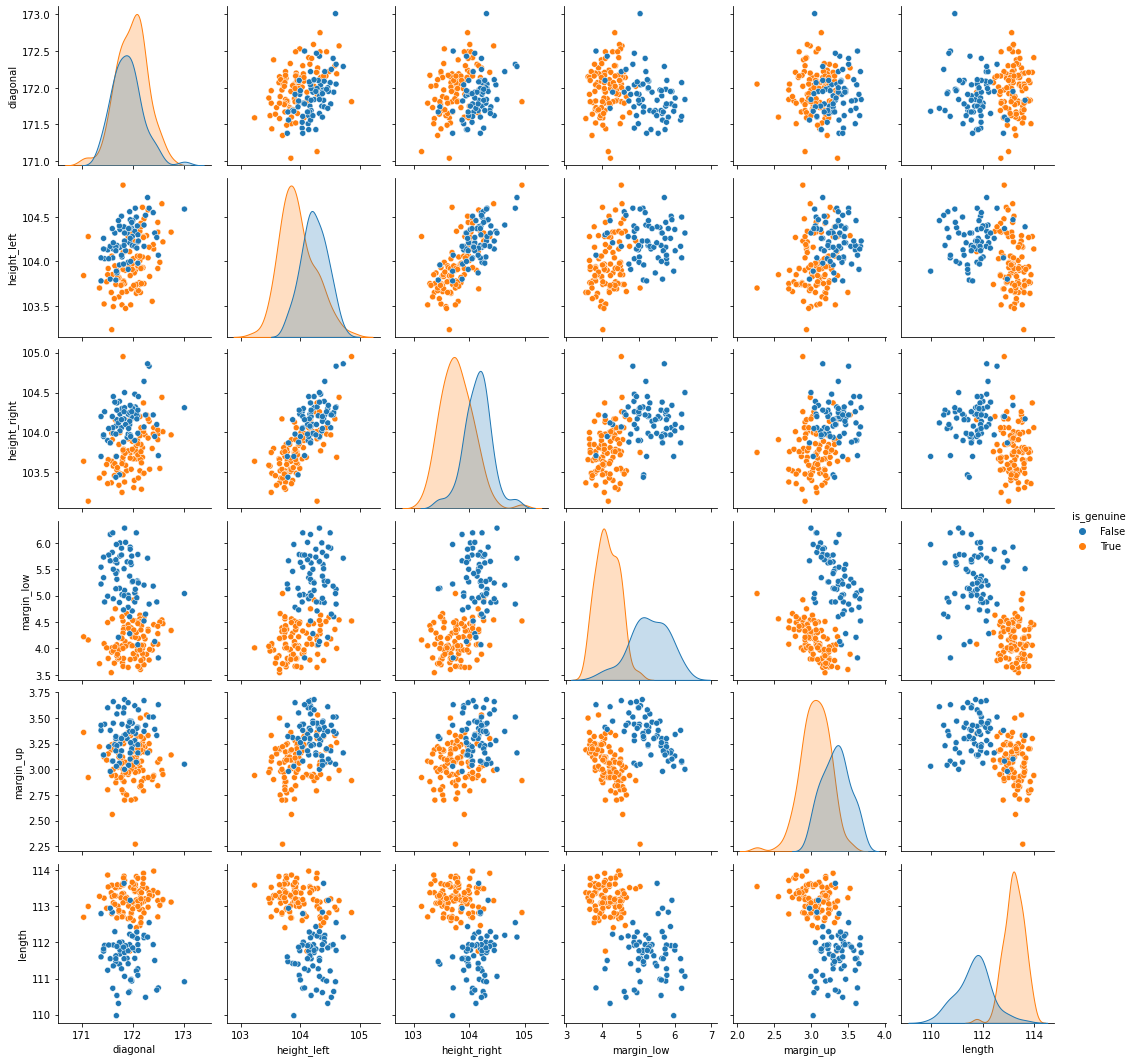

In [5]:
sns.pairplot(data=df, hue = 'is_genuine')

According to the pair plot, the best variable separing the True and False is the length

<AxesSubplot:>

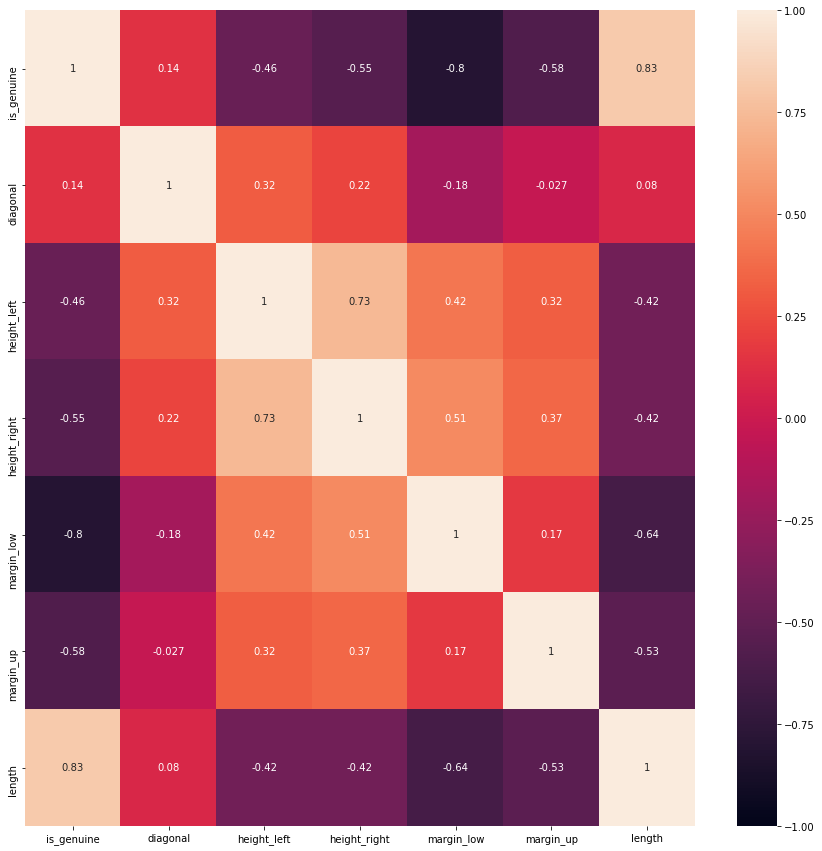

In [6]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),vmin=-1, vmax=1, annot=True)

Again the better correlation with obtain for the genuine is the length. Perhaps a logistic regression with this variable would be a good way to predict the genuine of a new bill.

# Encoding the genuine Variable

Let's replace the True into 1 and the False into 0.

In [7]:
def encoding_genuine(x):
    if x == False:
        return 0
    if x == True:
        return 1
df['is_new_genuine'] = df['is_genuine'].apply(encoding_genuine)
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,is_new_genuine
0,True,171.81,104.86,104.95,4.52,2.89,112.83,1
1,True,171.67,103.74,103.70,4.01,2.87,113.29,1
2,True,171.83,103.76,103.76,4.40,2.88,113.84,1
3,True,171.80,103.78,103.65,3.73,3.12,113.63,1
4,True,172.05,103.70,103.75,5.04,2.27,113.55,1


## Partie 2 : ANALYSE EN COMPOSANTES PRINCIPALES

Repartez de l'exploration via l'étude VISA pour cette partie + le cours sur OC
Dans tous les cas, je veux voir ce que j'ai cité plus haut.

In [8]:
features = ['diagonal', 'height_left', 'height_right', 'margin_low','margin_up','length']
# Separating out the features
x = df.loc[:, features].values
# Separating out the target
y = df.loc[:,['is_genuine']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [9]:
pca = PCA()
principalComponents = pca.fit_transform(x)

pca.explained_variance_ratio_

array([0.47447921, 0.21957106, 0.14234524, 0.08526295, 0.04612822,
       0.03221331])

The best component would be 3 but we can choose only 2 because the dataset is created by hand. So the values are perfect. 

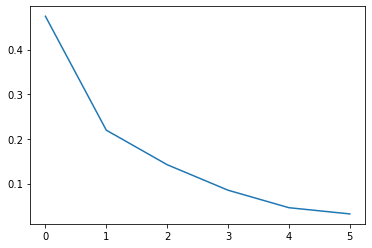

In [10]:
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.show()

# Analyse de la Composante Principale 

In [11]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
df_pca = pd.concat([principalDf, df[['is_genuine']]], axis = 1)
df_pca

,principal component 1,principal component 2,is_genuine
0,2.153639,1.599709,True
1,-2.110416,-0.526039,True
2,-1.973152,-0.048102,True
3,-2.059795,-0.089105,True
4,-2.403180,0.412170,True
...,...,...,...
165,2.478626,0.189974,False
166,2.585331,2.914472,False
167,2.067245,0.845602,False
168,0.739257,-0.972965,False


# Cercle des Corrélations 

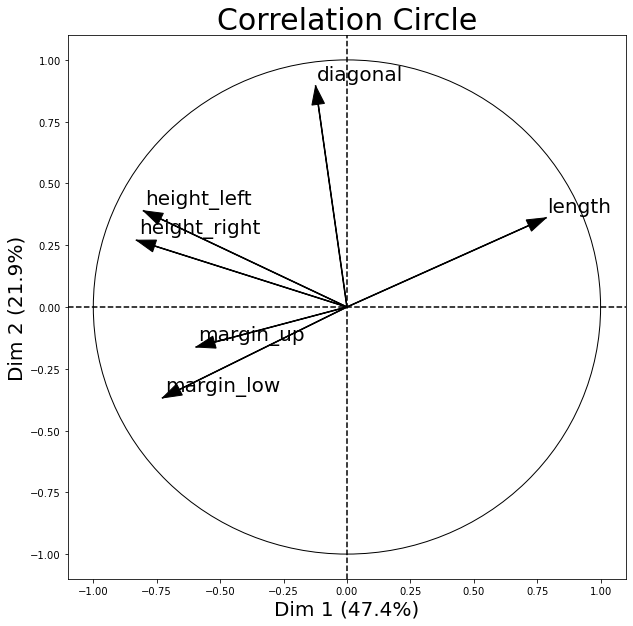

In [12]:
from mlxtend.plotting import plot_pca_correlation_graph

figure, correlation_matrix = plot_pca_correlation_graph(x,
                                                        features,
                                                        dimensions=(1, 2),
                                                        figure_axis_size=10)

D'après le cercle de corrélations:  
-Les variables Height left et right sont corrélées positivement <br>
-Les variables margin up et low sont corrélées positivement  
-La variable diagonale ne semble pas offrir beaucoup de corrélation entre les autres  
-La variables length est corrélé négativement avec toute les variables excepté diagonale  
  
  Une regression logistique avec la variable length semble être encore une fois favorable pour de la prédiction
  


# représentation des individus 

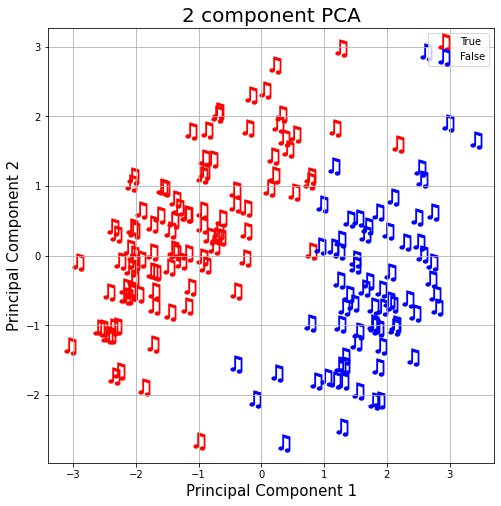

In [13]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [True, False]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = df_pca['is_genuine'] == target
    ax.scatter(df_pca.loc[indicesToKeep, 'principal component 1']
               , df_pca.loc[indicesToKeep, 'principal component 2']
               , c = color
               ,marker='$\u266B$'
               , s = 300)
ax.legend(targets)
ax.grid()

On voit parfaitement une bonne distinction entre les valeurs True et False. Nos deux composantes principales fonctionnent et nous permette créer des cluster. Nous pouvons donc essayer une technique de Kmeans par la suite. 

## Partie 3 : PREDICTION

Effectuer la prédiction de nouveaux billets via un algorithme que vous allez mettre en place (kmeans? regression logistique? A vous de voir).  

In [14]:
df_reg = df.drop('is_genuine',axis=1)

# 🏋️‍♀️Train and Test Data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_reg[['length']],df_reg.is_new_genuine,test_size = 0.3)

# Regression Logistique 

Text(0, 0.5, 'Is True or False')

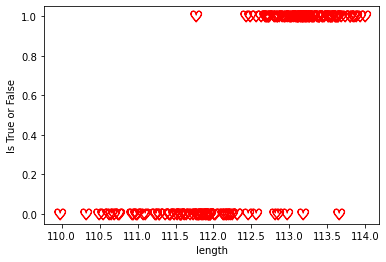

In [16]:
plt.scatter(df_reg.length,df_reg.is_new_genuine, c='r',marker='$\heartsuit$', s=150)
plt.xlabel('length')
plt.ylabel('Is True or False')

Visiblement la variable length offre une bonne logistique regression avec la variable genuine

In [17]:
model = LogisticRegression()

In [18]:
model.fit(X_train,y_train)

LogisticRegression()

In [19]:
model.predict(X_test)

array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [20]:
model.score(X_test,y_test)

0.9607843137254902

Le score est excellent. Bien sûr avec un vrai jeux de donnée ce score semblerait suspect mais il s'agit ici d'un jeu de donnée pour s'exercer

# Modèle de K-Means

On sait d'avance que nous n'avait besoin que de deux cluster (True et False).

In [21]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(df_pca)

In [22]:
kmeans.labels_


array([0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [23]:
kmeans.predict(df_pca)

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [24]:
kmeans.cluster_centers_

array([[ 1.67461094, -0.33228437,  0.08      ],
       [-1.32206127,  0.26232977,  0.98947368]])

In [25]:
df_pca['k'] = kmeans.predict(df_pca)

In [26]:
df_pca.value_counts('k')

k
1    95
0    75
dtype: int64

On obtient environ les mêmes valeurs de true et False 

In [43]:
df_pca.head()

,principal component 1,principal component 2,is_genuine,k
0,2.153639,1.599709,True,0
1,-2.110416,-0.526039,True,1
2,-1.973152,-0.048102,True,1
3,-2.059795,-0.089105,True,1
4,-2.403180,0.412170,True,1


Text(0, 0.5, 'principal component 1')

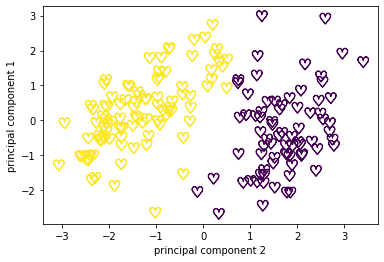

In [56]:
plt.scatter(df_pca['principal component 1'],df_pca['principal component 2'], c=df_pca['k'],marker='$\heartsuit$',s=150)
plt.xlabel('principal component 2')
plt.ylabel('principal component 1')


Ici, on distingue parfaitement nos deux clusters.

In [28]:
score = metrics.silhouette_score(df_pca, kmeans.labels_,metric = "euclidean" )
score

0.5404613251693409

The score is bad 😭

# Dendrograme

In [29]:
z = linkage(df_pca,method='ward',metric='euclidean')

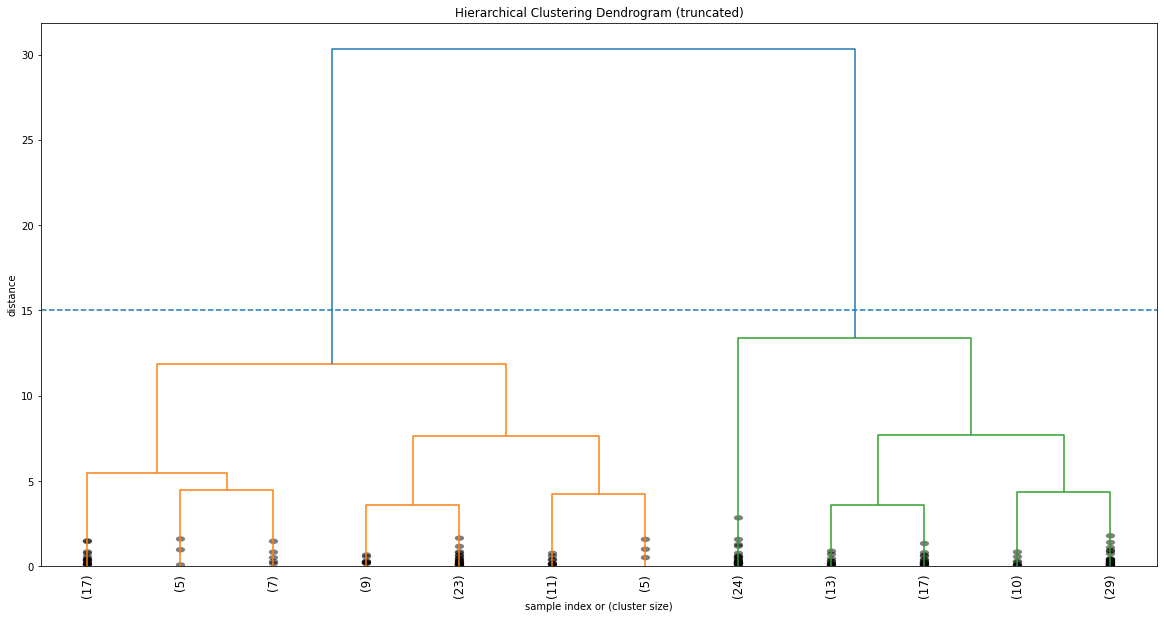

In [30]:
plt.figure(figsize=(20,10))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
plt.axhline(linestyle='--', y=15) 
dendrogram(
    z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

On observe bien nos deux clusters à une distance de 15

# Prédiction

Amusons-nous à prédire de nouvelles valeurs avec nos modèles

pour une valeur de billet de 110 et 114 cm de longueur par exemple

In [31]:
model.predict([[110]])

array([0], dtype=int64)

In [58]:
model.predict([[114]])

array([1], dtype=int64)

Pour le k-mean, il faudrait importer un nouveau jeu de donnée et appliqué la pca pour prédire les nouveaux clusters